In [1]:
import logging
import multiprocessing as mp
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence

from datasets import load_dataset
from datasets.formatting.formatting import LazyRow
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast, DataCollatorForSeq2Seq
import torch
from tqdm.notebook import tqdm
from torchmetrics import MetricCollection

from metrics import MRR, Accuracy
from metrics.bleu import SacreBLEUScore
from metrics.rouge import ROUGEScore
import json
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
class CommitChroniclePreprocessor:
    def __init__(
        self,
        diff_line_sep: str = "\n",
        languages: Optional[Sequence[str]] = ("Go",),
        change_types: Optional[Sequence[str]] = ("ADD",),
        cpu_count: Optional[int] = None,
        huggingface_path: str = "JetBrains-Research/commit-chronicle",
    ) -> None:
        """
        Args:
            diff_line_sep:  Line separator in diffs.
            languages:
            change_types:
            cpu_count:
        """
        super().__init__()

        self.diff_line_sep = diff_line_sep
        self.languages = languages
        self.cpu_count = cpu_count or mp.cpu_count()
        self.change_types = change_types
        self.huggingface_path = huggingface_path

    def __call__(self, output_dir: Path, split: str, use_cache: bool) -> None:
        """Main processing logic.

        Args:
            output_dir: Path to directory to save processed files.
            split: Current dataset split.
            use_cache: True to use already processed files when possible, False otherwise.

        Returns:
            Path to processed dataset
        """
        if use_cache and output_dir.exists():
            logging.info(f"Processed data found at '{output_dir}', won't rewrite")
        else:
            dataset = load_dataset(self.huggingface_path, "default", split=split)

            if self.languages:
                logging.info(f"Filtering by languages: {self.languages}")
                dataset = dataset.filter(
                    lambda example: example["language"] in self.languages,
                    num_proc=self.cpu_count,
                )
            if self.change_types:
                logging.info(f"Filtering by change types: {self.change_types}")
                dataset = dataset.filter(
                    lambda example: all(
                        mod["change_type"] in self.change_types for mod in example["mods"]
                    ),
                    num_proc=self.cpu_count,
                )
            dataset.map(self._process_example, num_proc=self.cpu_count).select_columns(
                ["diff", "msg", "repo"]
            ).save_to_disk(output_dir)

    def _process_example(self, example: LazyRow) -> Dict[str, Any]:
        """Processes a single example."""
        message = self._preprocess_message(example["message"])
        mods = self._preprocess_mods(example["mods"])
        return {
            "diff": mods,
            "msg": message,
            "repo": example["repo"],
        }

    def _preprocess_diff(self, diff: str) -> str:
        """Return given diff without any changes."""
        return diff

    def _preprocess_mods(self, mods: List[Dict[str, str]]) -> str:
        """Transforms a list of all files modifications made in a commit into a single string
        representation.

        Specifically, adds a header to each file diff (https://git-scm.com/docs/git-diff#_generating_patch_text_with_p)
        and concatenates the results.

        Args:
            mods: A list of files modifications made in a commit.

        Returns:
            A single string representation of all files modifications made in a commit.
        """
        line_sep = self.diff_line_sep
        diff = ""
        for mod in mods:
            if mod["change_type"] == "UNKNOWN":
                continue
            elif mod["change_type"] == "ADD":
                file_diff = f"new file {mod['new_path']}"
            elif mod["change_type"] == "DELETE":
                file_diff = f"deleted file {mod['old_path']}"
            elif mod["change_type"] == "RENAME":
                file_diff = f"rename from {mod['old_path']}{line_sep}rename to {mod['new_path']}"
            elif mod["change_type"] == "COPY":
                file_diff = f"copy from {mod['old_path']}{line_sep}copy to {mod['new_path']}"
            else:
                file_diff = f"{mod['new_path']}"
            diff += file_diff + line_sep + self._preprocess_diff(mod["diff"])

        return diff

    def _preprocess_message(self, message: str) -> str:
        """Returns given message without any changes."""
        return message


In [3]:
def tokenize_function(examples, diff_tokenizer, msg_tokenizer, diff_max_len, msg_max_len):
    inputs = diff_tokenizer(examples["diff"], max_length=diff_max_len, truncation=True)
    labels = msg_tokenizer(examples["msg"], max_length=msg_max_len, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [4]:
class _DataCollator:
    def __init__(self, tokenizer: PreTrainedTokenizerFast):
        self.collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

    def __call__(self, examples):
        batch = self.collator(examples)
        return {k:v.to(device) for k,v in batch.items()}

In [5]:
processor = CommitChroniclePreprocessor(
            diff_line_sep='\n',
            change_types=['ADD'],
            languages=['Go'],
            huggingface_path="UHHBois/commit-chronicle-dataset-simplified"
        )

In [6]:
metrics = MetricCollection(
            {
                "sacre_bleu1": SacreBLEUScore(n_gram=1),
                "sacre_bleu4": SacreBLEUScore(n_gram=4),
                "rouge1": ROUGEScore(rouge_keys="rouge1")["rouge1_fmeasure"],
                "rouge2": ROUGEScore(rouge_keys="rouge2")["rouge2_fmeasure"],
                "rougeL": ROUGEScore(rouge_keys="rougeL")["rougeL_fmeasure"],
                "rougeLsum": ROUGEScore(rouge_keys="rougeLsum")["rougeLsum_fmeasure"],
            }
        )

In [7]:
device = (torch.device("cuda:0")
          if torch.cuda.is_available() else torch.device("cpu"))  # 使用cpu或者gpu

In [22]:
def get_eval_res(model_name_or_path, flag):
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="left")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    processed_path = ".tmp"
    split = "test"
    processor(
        output_dir=processed_path,
        split=split,
        use_cache=False,
    )
    dataset = load_from_disk(processed_path)
    dataset = dataset.map(
        tokenize_function,
        fn_kwargs={
            "diff_tokenizer": tokenizer,
            "msg_tokenizer": tokenizer,
            "diff_max_len": 1008,
            "msg_max_len": 16,
        },
        batched=True,
        batch_size=1000,
        remove_columns=dataset.column_names,
        num_proc=max(1, mp.cpu_count() - 1),
    )
    batch_size = 4
    data_loader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                num_workers=0,
                pin_memory=False,
                shuffle=True,
                collate_fn=_DataCollator(tokenizer),
                persistent_workers=False,
            )
    model = AutoModelForCausalLM.from_pretrained(
            "./Qwen2.5-0.5B-Instruct/",
            torch_dtype="auto",
            device_map=device
    )
    results = []
    for model_inputs in tqdm(data_loader, total=len(data_loader), desc="Predict"):
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=16
        )
        generated_ids = generated_ids[:, model_inputs["input_ids"].shape[-1]:]
        labels = torch.where(model_inputs["labels"] == -100, tokenizer.pad_token_id, model_inputs["labels"])
        predictions = torch.where(generated_ids == -100, tokenizer.pad_token_id, generated_ids)
        labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        for (
            pred,
            target,
            ) in zip(predictions, labels):
                item = {
                    "prediction": pred,
                    "target": target,
                }
                results.append(item)
    predictions, targets = zip(
            *[(result["prediction"], [result["target"]]) for result in results]
        )
    out = {k: v.item() for k,v in metrics(predictions, targets).items()}
    print(f"Saved to {flag}_metric.json, out: {out}")
    with open(f"{flag}_metric.json", "w", encoding="utf-8") as f:
        json.dump(out, f)

In [10]:
get_eval_res("./Qwen2.5-0.5B-Instruct/", "Qwen2.5-0.5B-Instruct")

Using the latest cached version of the dataset since UHHBois/commit-chronicle-dataset-simplified couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/UHHBois___commit-chronicle-dataset-simplified/default/0.0.0/b1cd27f069206100d0e0500bc89baf81898dd006 (last modified on Fri Jan 24 09:33:12 2025).


Saving the dataset (0/1 shards):   0%|          | 0/3800 [00:00<?, ? examples/s]

Map (num_proc=111):   0%|          | 0/3800 [00:00<?, ? examples/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Saved to Qwen2.5-0.5B-Instruct_metric.json, out: {'rouge1': 0.07222182303667068, 'rouge2': 0.0118928337469697, 'rougeL': 0.0662565529346466, 'rougeLsum': 0.06648113578557968, 'sacre_bleu1': 0.039654817432165146, 'sacre_bleu4': 0.004977384582161903}


In [23]:
get_eval_res("./Llama-3.2-1B-Instruct/", "Llama-3.2-1B-Instruct")

Using the latest cached version of the dataset since UHHBois/commit-chronicle-dataset-simplified couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/UHHBois___commit-chronicle-dataset-simplified/default/0.0.0/b1cd27f069206100d0e0500bc89baf81898dd006 (last modified on Fri Jan 24 09:33:12 2025).


Saving the dataset (0/1 shards):   0%|          | 0/3800 [00:00<?, ? examples/s]

Map (num_proc=111):   0%|          | 0/3800 [00:00<?, ? examples/s]

Predict:   0%|          | 0/950 [00:00<?, ?it/s]

Saved to Llama-3.2-1B-Instruct_metric.json, out: {'rouge1': 0.03813420608639717, 'rouge2': 0.0044251056388020515, 'rougeL': 0.03558635339140892, 'rougeLsum': 0.03573759272694588, 'sacre_bleu1': 0.027865136042237282, 'sacre_bleu4': 0.002037294441834092}


In [7]:
def get_value(file, key):
    with open(file, "r", encoding="utf-8") as f:
        js = json.load(f)
    for k,v in js.items():
        if key in k:
            return v

In [23]:
def plot_bar(files, metic):
    a = []
    b = []
    for file in files:
        a.append(file[:-12])
        b.append(get_value(file, metic))
    fig, ax = plt.subplots()
    rect = ax.bar(a, b, width=0.4)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height)[:6],
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_title(f'{metic}')
    ax.set_xticks(a)
    ax.set_xticklabels(a, rotation=0)
    autolabel(rect)
    plt.show()

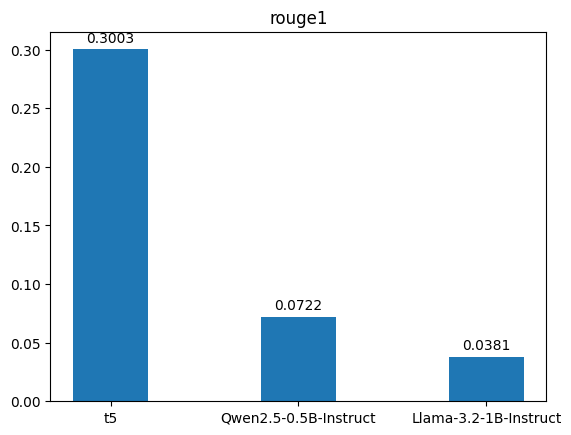

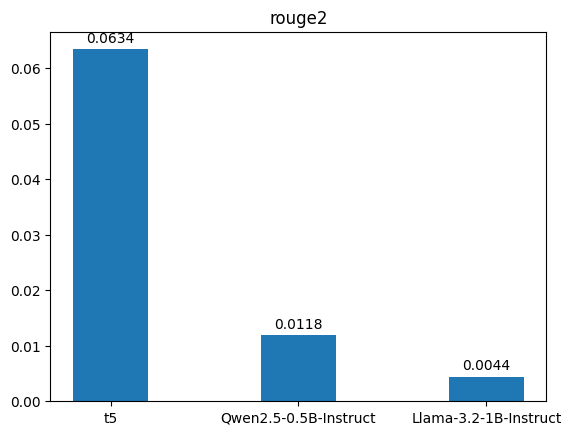

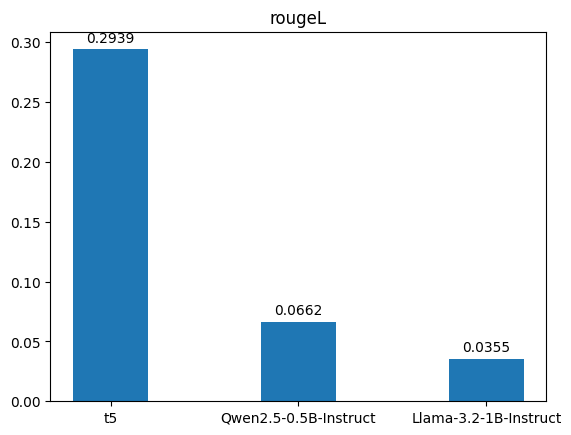

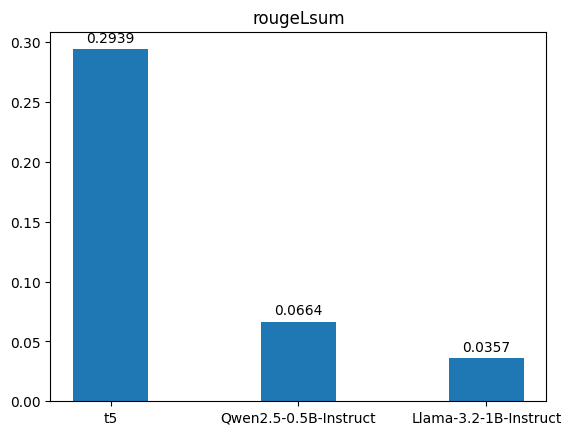

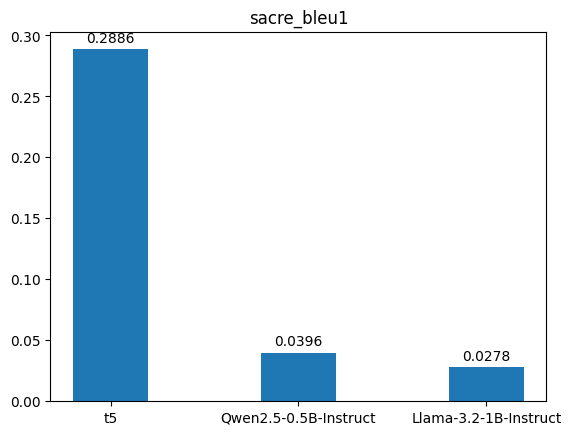

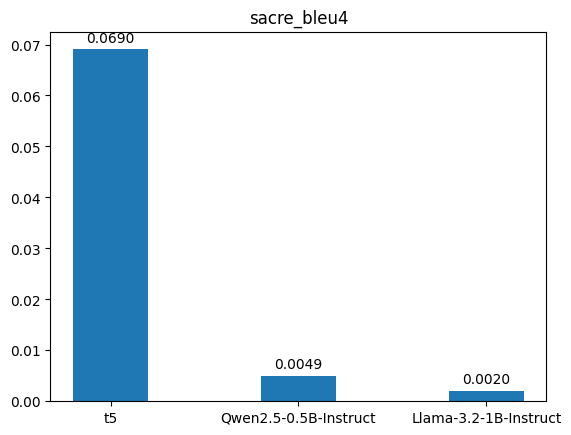

In [24]:
metic = ["rouge1", "rouge2", "rougeL", "rougeLsum", "sacre_bleu1", "sacre_bleu4"]
files = ["t5_metric.json", "Qwen2.5-0.5B-Instruct_metric.json", "Llama-3.2-1B-Instruct_metric.json"]
for i in metic:
    plot_bar(files, i)